In [1]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt
from numpy import linalg as LA
import copy
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [3]:
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one','two'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2


all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
background_classes

{'eight', 'five', 'four', 'nine', 'seven', 'six', 'three'}

In [4]:
gamma = 5*1e-3
train = trainset.data
label = trainset.targets

In [5]:
train = np.reshape(train, (60000,784))
train.shape

torch.Size([60000, 784])

In [7]:
u, s, vh = LA.svd(train, full_matrices= False)

In [8]:
dir = vh[600:610,:]  #vh[774:784,:] #vh[0:9,:] 
u1 = dir[7,:]
u2 = dir[8,:]
u3 = dir[9,:]

In [9]:
cnt=0
for i in range(60000):
  if(label[i] == fg1):
    # print(train[i])
    # print(LA.norm(train[i]))
    # print(u1)
    train[i] = train[i] + gamma * LA.norm(train[i]) * u1
    # print(train[i])
    cnt+=1

  if(label[i] == fg2):
    train[i] = train[i] + gamma * LA.norm(train[i]) * u2
    cnt+=1

  if(label[i] == fg3):
    train[i] = train[i] + gamma * LA.norm(train[i]) * u3
    cnt+=1

  if(i%10000 == 9999):
    print("partly over")
    print(cnt)

partly over
3119
partly over
6204
partly over
9332
partly over
12430
partly over
15578
partly over
18623


In [10]:
train = np.reshape(train, (60000,28, 28))
trainset.data = train
test = testset.data
label = testset.targets
test = np.reshape(test, (10000,784))
test.shape

torch.Size([10000, 784])

In [11]:
cnt=0
for i in range(10000):
  if(label[i] == fg1):
    # print(train[i])
    # print(LA.norm(train[i]))
    # print(u1)
    test[i] = test[i] + gamma * LA.norm(test[i]) * u1
    # print(train[i])
    cnt+=1

  if(label[i] == fg2):
    test[i] = test[i] + gamma * LA.norm(test[i]) * u2
    cnt+=1

  if(label[i] == fg3):
    test[i] = test[i] + gamma * LA.norm(test[i]) * u3
    cnt+=1

  if(i%1000 == 999):
    print("partly over")
    print(cnt)

partly over
327
partly over
628
partly over
924
partly over
1238
partly over
1561
partly over
1879
partly over
2196
partly over
2512
partly over
2827
partly over
3147


In [12]:
test = np.reshape(test, (10000,28, 28))
test.shape

torch.Size([10000, 28, 28])

In [13]:
testset.data = test

In [14]:
fg = [fg1,fg2,fg3]
bg = list(set([0,1,2,3,4,5,6,7,8,9])-set(fg))
fg,bg

([0, 1, 2], [3, 4, 5, 6, 7, 8, 9])

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

In [16]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(6000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [17]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [18]:
desired_num = 10000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [19]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+30000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [20]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([ 28,28], dtype=torch.float64)
    for j in range(9):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index

In [21]:

def create_avg_image_from_mosaic_dataset_fraction(mosaic_dataset,labels,foreground_index,dataset_number, fraction):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([ 28,28], dtype=torch.float64)
    np.random.seed(dataset_number*10000 + i)
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(9):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*fraction/9
      else :
        img = img + mosaic_dataset[i][j]*(9-fraction)/(8*9)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index

In [35]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 1)

avg_image_dataset_1_01 , labels_1_01,  fg_index_2 = create_avg_image_from_mosaic_dataset_fraction(mosaic_list_of_images, mosaic_label, fore_idx, 2,1.01)
avg_image_dataset_1_02, labels_1_02,  fg_index_3 = create_avg_image_from_mosaic_dataset_fraction(mosaic_list_of_images, mosaic_label, fore_idx , 3, 1.02)
avg_image_dataset_1_1 , labels_1_1,  fg_index_4 = create_avg_image_from_mosaic_dataset_fraction(mosaic_list_of_images, mosaic_label, fore_idx , 4, 1.1)
avg_image_dataset_1_2 , labels_1_2,  fg_index_4 = create_avg_image_from_mosaic_dataset_fraction(mosaic_list_of_images, mosaic_label, fore_idx , 5, 1.2)
avg_image_dataset_1_5 , labels_1_5,  fg_index_4 = create_avg_image_from_mosaic_dataset_fraction(mosaic_list_of_images, mosaic_label, fore_idx , 6, 1.5)


avg_test_1 , labels_test_1,  fg_index_test_1 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 1)
avg_test_1_01 , labels_test_1_01,  fg_index_test_2 = create_avg_image_from_mosaic_dataset_fraction(test_images, test_label, fore_idx_test , 2,1.01)
avg_test_1_02, labels_test_1_02,  fg_index_test_3 = create_avg_image_from_mosaic_dataset_fraction(test_images, test_label, fore_idx_test , 3,1.02)
avg_test_1_1 , labels_test_1_1,  fg_index_test_4 = create_avg_image_from_mosaic_dataset_fraction(test_images, test_label, fore_idx_test , 4,1.1)
avg_test_1_2 , labels_test_1_2,  fg_index_test_5 = create_avg_image_from_mosaic_dataset_fraction(test_images, test_label, fore_idx_test , 5,1.2)
avg_test_1_5 , labels_test_1_5,  fg_index_test_6 = create_avg_image_from_mosaic_dataset_fraction(test_images, test_label, fore_idx_test , 6,1.5)

avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 3)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 4)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 5)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 6)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 7)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 8)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 9)


avg_test_2 , labels_test_2,  fg_index_test_2 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 2)
avg_test_3 , labels_test_3,  fg_index_test_3 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 3)
avg_test_4 , labels_test_4,  fg_index_test_4 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 4)
avg_test_5 , labels_test_5,  fg_index_test_5 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 5)
avg_test_6 , labels_test_6,  fg_index_test_6 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 6)
avg_test_7 , labels_test_7,  fg_index_test_7 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 7)
avg_test_8 , labels_test_8,  fg_index_test_8 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 8)
avg_test_9 , labels_test_9,  fg_index_test_9 = create_avg_image_from_mosaic_dataset(test_images, test_label, fore_idx_test , 9)

number of correct averaging happened for dataset 2 is 10000
the averaging are done as  [1129 1106 1131 1110 1166 1103 1078 1087 1090]
number of correct averaging happened for dataset 3 is 10000
the averaging are done as  [1129 1106 1131 1110 1166 1103 1078 1087 1090]
number of correct averaging happened for dataset 4 is 10000
the averaging are done as  [1129 1106 1131 1110 1166 1103 1078 1087 1090]
number of correct averaging happened for dataset 5 is 10000
the averaging are done as  [1129 1106 1131 1110 1166 1103 1078 1087 1090]
number of correct averaging happened for dataset 6 is 10000
the averaging are done as  [1129 1106 1131 1110 1166 1103 1078 1087 1090]
number of correct averaging happened for dataset 2 is 10000
the averaging are done as  [1078 1153 1127 1132 1142 1070 1115 1077 1106]
number of correct averaging happened for dataset 3 is 10000
the averaging are done as  [1078 1153 1127 1132 1142 1070 1115 1077 1106]
number of correct averaging happened for dataset 4 is 10000
th

In [36]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [37]:
batch = 256
epochs = 65

# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_1_01 = MosaicDataset(avg_image_dataset_1_01, labels_1_01 )
trainloader_1_01 = DataLoader( traindata_1_01 , batch_size= batch ,shuffle=True)


traindata_1_02 = MosaicDataset(avg_image_dataset_1_02, labels_1_02 )
trainloader_1_02 = DataLoader( traindata_1_02 , batch_size= batch ,shuffle=True)

traindata_1_1 = MosaicDataset(avg_image_dataset_1_1, labels_1_1 )
trainloader_1_1 = DataLoader( traindata_1_1 , batch_size= batch ,shuffle=True)

traindata_1_2 = MosaicDataset(avg_image_dataset_1_2, labels_1_2 )
trainloader_1_2 = DataLoader( traindata_1_2 , batch_size= batch ,shuffle=True)

traindata_1_5 = MosaicDataset(avg_image_dataset_1_5, labels_1_5 )
trainloader_1_5 = DataLoader( traindata_1_5 , batch_size= batch ,shuffle=True)

testdata_1 = MosaicDataset(avg_test_1, labels_test_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_1_01 = MosaicDataset(avg_test_1_01, labels_test_1_01 )
testloader_1_01 = DataLoader( testdata_1_01 , batch_size= batch ,shuffle=False)

testdata_1_02 = MosaicDataset(avg_test_1_02, labels_test_1_02 )
testloader_1_02 = DataLoader( testdata_1_02 , batch_size= batch ,shuffle=False)

testdata_1_1 = MosaicDataset(avg_test_1_1, labels_test_1_1 )
testloader_1_1 = DataLoader( testdata_1_1 , batch_size= batch ,shuffle=False)

testdata_1_2 = MosaicDataset(avg_test_1_2, labels_test_1_2 )
testloader_1_2 = DataLoader( testdata_1_2 , batch_size= batch ,shuffle=False)

testdata_1_5 = MosaicDataset(avg_test_1_5, labels_test_1_5 )
testloader_1_5 = DataLoader( testdata_1_5 , batch_size= batch ,shuffle=False)

# traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
# trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

# testdata_1 = MosaicDataset(avg_test_1, labels_test_1 )
# testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_test_2, labels_test_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_test_3, labels_test_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_test_4, labels_test_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_test_5, labels_test_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_test_6, labels_test_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_test_7, labels_test_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_test_8, labels_test_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_test_9, labels_test_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

In [38]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f,track_running_stats=False)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [39]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [40]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [41]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(1,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(236,3)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear(x) 
        return x

In [42]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/i

In [43]:
def test_all(number, testloader,inc):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= inc(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test dataset %d: %d %%' % (number , 100 * correct / total))

In [44]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    inc = inception_net().double()
    inc = inc.to("cuda")
    
    criterion_inception = nn.CrossEntropyLoss()
    optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 70
    running_loss = calculate_loss(trainloader,inc,criterion_inception)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        inc.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_inception.zero_grad()

            # forward + backward + optimize
            outputs = inc(inputs)
            loss = criterion_inception(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_inception.step()

        running_loss = calculate_loss(trainloader,inc,criterion_inception)
        print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.001:
          break
    #     if (epoch%5 == 0):
    #         _,actis= inc(inputs)
    #         acti.append(actis)



    print('Finished Training')
    #torch.save(inc.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = inc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,inc)
    
    print("--"*40)
    
    return loss_curi
    

In [46]:
train_loss_all=[]

testloader_list= [ testloader_1,testloader_1_01,testloader_1_02,testloader_1_1, testloader_1_2, testloader_1_5,
                  testloader_2,testloader_3,testloader_4,testloader_5,testloader_6,testloader_7,testloader_8,testloader_9]

train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_1_01, 101, testloader_list))
train_loss_all.append(train_all(trainloader_1_02, 102, testloader_list))
train_loss_all.append(train_all(trainloader_1_1, 11, testloader_list))
train_loss_all.append(train_all(trainloader_1_2, 12, testloader_list))
train_loss_all.append(train_all(trainloader_1_5, 15, testloader_list))



train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 1.138
epoch: [1] loss: 0.009
epoch: [2] loss: 0.003
epoch: [3] loss: 0.002
epoch: [4] loss: 0.001
epoch: [5] loss: 0.001
epoch: [6] loss: 0.001
epoch: [7] loss: 0.001
epoch: [8] loss: 0.001
Finished Training
Accuracy of the network on the 10000 train images: 100 %
Accuracy of the network on the 10000 test dataset 1: 100 %
Accuracy of the network on the 10000 test dataset 2: 100 %
Accuracy of the network on the 10000 test dataset 3: 100 %
Accuracy of the network on the 10000 test dataset 4: 100 %
Accuracy of the network on the 10000 test dataset 5: 100 %
Accuracy of the network on the 10000 test dataset 6: 100 %
Accuracy of the network on the 10000 test dataset 7: 100 %
Accuracy of the network on the 10000 test dataset 8: 100 %
Accuracy of the network on the 10000 test dataset 9: 100 %
Accuracy of the network on the 10000 test dataset 10: 100 %
Accuracy of the netw

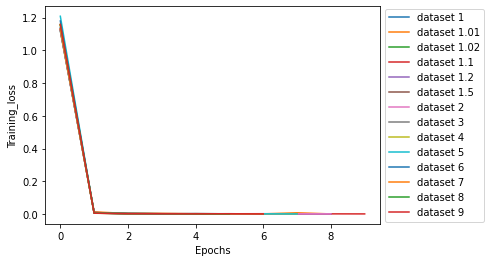

In [49]:
curve_lbl = ["1","1.01","1.02","1.1","1.2","1.5","2","3","4","5","6","7","8","9"]
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+curve_lbl[i])
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("mnist_direction_2.pdf")
plt.savefig("mnist_direction_2.png")